# Estimating the probability of future customer engagement


A method that can be used to analyze customer value is RFM:
* **R**ecency: how recently did the customer purchase?
* **F**requency: how often do they purchase?
* **M**onetary Value: how much do they spend?

The [lifetimes](https://github.com/CamDavidsonPilon/lifetimes) library, that will be used here to analyze our customers, is based on a few assumptions according to its author:
*  users interact with you when they are "alive"
*  users under study may "die" after some period of time

Considering this, `lifetimes` can be used to predict customers individuals who have churned from the service using only their usage history and we can define our own definiton of "alive" or "die":
* live: logins registered by online sessions
* die: removed the service 

This library is based on the work developed by [Peter Fader and others](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/06/BGNBD_FHL_MktgSci_2005_1.pdf) and the model is called Beta Geometric/Negative Binomial Distribution model (BG/NBD). It's interesting to note that this model allows for customers with no repeated transactions.

## Definitions

To build our model we need to obtain the following metrics:
* **frequency**:  
  * the number of dates on which a customer made a purchase subsequent to the date of the customer's first purchase
* **T**(age):
  * the number of time units (e.g. weeks, days, etc) since the date of a customer's first purchase to the current date (or last date in the dataset)
* **recency**:
  * the age(T) of the customer at the time of their last purchase
  **monetary_value**:
  * is the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases.

For more details, please see the original [documentation](https://lifetimes.readthedocs.io/en/latest/index.html).

Moreover, to be able to use the library `lifetimes`and its functionalities we should put our data in the required format. 

In [1]:
# importing libraries
import datetime as dt
from joblib import dump
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# importing lifetimes
import lifetimes
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.datasets import load_transaction_data
from lifetimes.plotting import (
    plot_calibration_purchases_vs_holdout_purchases,
    plot_frequency_recency_matrix,
    plot_history_alive,
    plot_period_transactions,
    plot_probability_alive_matrix,
)
from lifetimes.utils import (
    calibration_and_holdout_data,
    summary_data_from_transaction_data,
)

In [2]:
# lifetimes library version
print(f"lifetimes version: {lifetimes.__version__}")

lifetimes version: 0.11.3


## Importing data

In [3]:
# reading the dataset
#churn = pd.read_csv("../data/df_from_eng.csv")
churn = pd.read_csv("../data/df_from_casino_classic.csv")

# convert object column to datetime format
churn["date"] = pd.to_datetime(churn["date"])

## Formating and exploring data

In [4]:
# show a summary data from a pandas DataFrame that contains the customer_id col and the datetime col.

# set time format: D=day, M=month, W=week
freq = "W"

observation_period_end = churn["date"].max()  # the last transaction date

rfm_metrics = summary_data_from_transaction_data(
    transactions=churn,
    customer_id_col="player_id_cat",
    datetime_col="date",
    monetary_value_col="session_sum",
    observation_period_end=observation_period_end,
    freq=freq,
)
rfm_metrics.head(4)

,frequency,recency,T,monetary_value
player_id_cat,,,,
1,23.0,46.0,48.0,3456.782609
2,17.0,45.0,46.0,1126.647059
4,0.0,0.0,39.0,0.000000
8,0.0,0.0,14.0,0.000000


From the above results we can observe that, for example, custumer with `player_id_cat = 4` :
* used the service only once (zero frequency and zero recency)
* the duration time between his first purchase and the end of the analysis period is 336 days

In [5]:
# numbers of custumers in the dataset
print(f'Number of custumers in the dataset: {churn["player_id_cat"].nunique()}')

Number of custumers in the dataset: 6808


         frequency      recency            T  monetary_value
count  6808.000000  6808.000000  6808.000000     6808.000000
mean      3.948884     9.535693    24.698149     6957.785714
std       7.259045    13.456596    15.674937    13814.660040
min       0.000000     0.000000     0.000000        0.000000
25%       0.000000     0.000000    10.000000        0.000000
50%       1.000000     2.000000    24.000000     2281.000000
75%       4.000000    16.000000    39.000000     7179.375000
max      51.000000    52.000000    52.000000   190704.000000

>>> 40.8% of custumers used the service only once



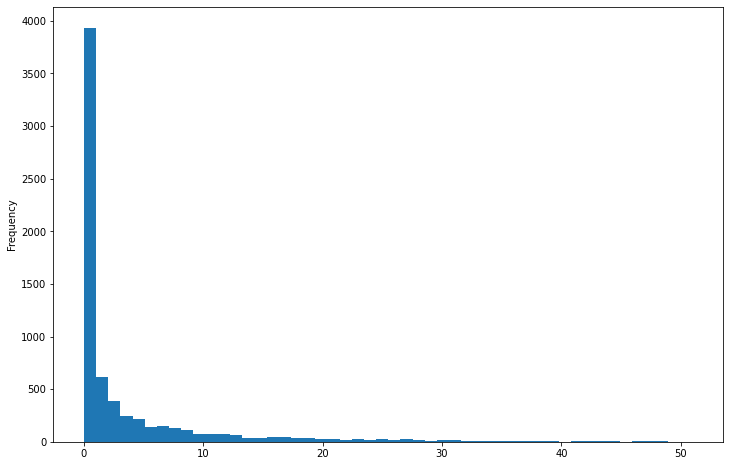

In [6]:
# print some sdescriptive statistics
# rfm = recency, frequency, monetary value
print(f"{rfm_metrics.describe()}")
print(
    f'\n>>> {round(sum(rfm_metrics["frequency"] == 0) / float(len(rfm_metrics))*100, 1)}% of custumers used the service only once\n'
)
# plot frequency
rfm_metrics["frequency"].plot(kind="hist", bins=50, **{"figsize": (12, 8)})
plt.show()
plt.close()

For our 9027 custumers, in a 52 weeks period, the above results show that:
* about 40.8% of the custumers only used the service once

## Spliting the data

We'll split the dataset into calibration (ealier in time) and holdout (later in time) periods. This is necessary for model validation and also to prevent overfitting.  

The holdout period will be equal to 110 days, what approximately corresponds to 30% of the total time inteval in the dataset.

In [7]:
# split the data into calibration and holdout
holdout_days = 110  # 30% of the time period in days
calibration__period_end = observation_period_end - dt.timedelta(days=holdout_days)

rfm_metrics_cal_holdout = calibration_and_holdout_data(
    churn,
    "player_id_cat",
    "date",
    calibration_period_end=calibration__period_end,
    observation_period_end=observation_period_end,
    freq=freq,
)

rfm_metrics_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
player_id_cat,,,,,
1,14.0,32.0,32.0,9.0,16.0
2,8.0,10.0,30.0,9.0,16.0
4,0.0,0.0,23.0,0.0,16.0
9,0.0,0.0,2.0,2.0,16.0
12,1.0,1.0,32.0,0.0,16.0


## Model building


Let's use the splitted dataset, first fitting the model using the calibration and then evaluating the model using the holdout.

In [8]:
# fit the model
model_bgf = BetaGeoFitter(penalizer_coef=0.0)
model_bgf.fit(
    rfm_metrics_cal_holdout["frequency_cal"],
    rfm_metrics_cal_holdout["recency_cal"],
    rfm_metrics_cal_holdout["T_cal"],
)

<lifetimes.BetaGeoFitter: fitted with 4402 subjects, a: 0.47, alpha: 1.56, b: 3.34, r: 0.43>

In [9]:
# show model parameters (r, alpha, a, b)
model_bgf.summary.coef

r        0.427373
alpha    1.556152
a        0.467786
b        3.343301
Name: coef, dtype: float64

After fitting the model we are able to make some predictions considering the holdout period.

In [10]:
# predicted frequency during holdout period
pred_freq_holdout = model_bgf.predict(
    rfm_metrics_cal_holdout["duration_holdout"],
    rfm_metrics_cal_holdout["frequency_cal"],
    rfm_metrics_cal_holdout["recency_cal"],
    rfm_metrics_cal_holdout["T_cal"],
)

# true frequency during holdout period
true_freq_holdout = rfm_metrics_cal_holdout["frequency_holdout"]

In [11]:
def model_eval(true, predicted, metric="mse"):
    # mean squared error and root mean squared error
    if metric == "mse" or metric == "rmse":
        val = np.sum(np.square(true - predicted)) / true.shape[0]
        if metric == "rmse":
            val = np.sqrt(val)
            return print(f"RMSE: {val}")
    # mean absolute error
    elif metric == "mae":
        val = np.sum(np.abs(true - predicted)) / true.shape[0]
        return print(f"MAE: {val}")
    else:
        val = None
    return print(f"MSE: {val}")

## Model evaluation

Once we have the true and predicted values we can now evaluate our model. A simple way to do this, is calculating the mean squared error, root mean squared error or mean absolute erro implemented in the user-defined function `model_eval`.

In [12]:
# evaluate the model
model_eval(true_freq_holdout, pred_freq_holdout, "mse")
model_eval(true_freq_holdout, pred_freq_holdout, "rmse")
model_eval(true_freq_holdout, pred_freq_holdout, "mae")

MSE: 7.38643018227433
RMSE: 2.717798775162416
MAE: 1.6235575569376972


A better approach to this is to compare purchase frequencies in the calibration period to relates to actual (frequency_holdout) and predicted (model_predictions) frequencies in the holdout period:

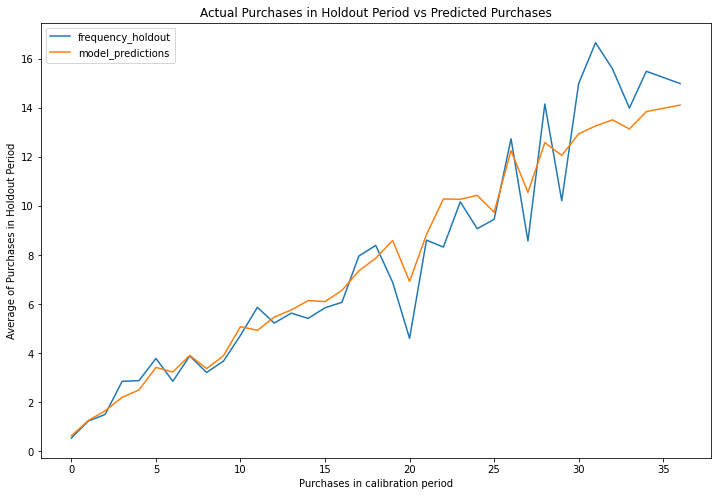

In [13]:
plot_calibration_purchases_vs_holdout_purchases(
    model_bgf,
    rfm_metrics_cal_holdout,
    kind="frequency_cal",
    n=36,
    **{"figsize": (12, 8)}
)
plt.show()
plt.close()

From the previous plot we see that the model was able to capture the general trends in the customer behaviour.

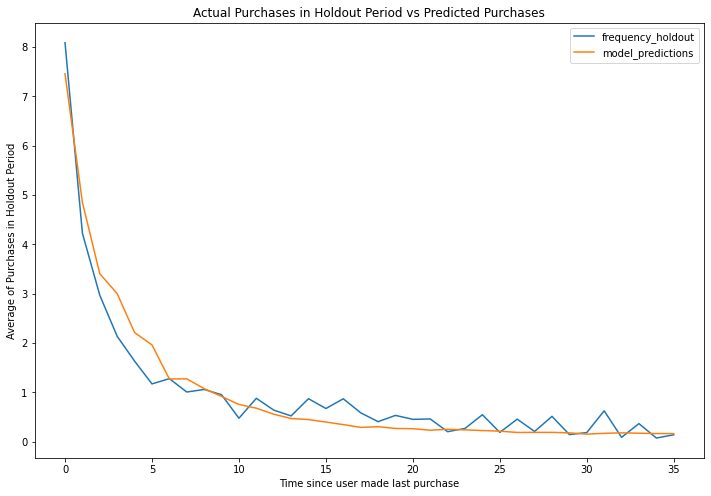

In [14]:
plot_calibration_purchases_vs_holdout_purchases(
    model_bgf,
    rfm_metrics_cal_holdout,
    kind="time_since_last_purchase",
    n=36,
    **{"figsize": (12, 8)}
)
plt.show()
plt.close()

The previous plot shows the time since user made last purchase (in weeks) relative to the average number of purchases in the holdout. When the time since last purchase increase, the number of purchases in the holdout decrease, what means that custumer who do not use the service for some time, probably will not come back.

Let's now calculate the probability a consumer is currently "alive".

In [15]:
# create a field with the probability a customer is currently "alive"

rfm_metrics["prob_alive"] = model_bgf.conditional_probability_alive(
    rfm_metrics["frequency"], 
    rfm_metrics["recency"], 
    rfm_metrics["T"]
)

rfm_metrics.head()

,frequency,recency,T,monetary_value,prob_alive
player_id_cat,,,,,
1,23.0,46.0,48.0,3456.782609,0.953786
2,17.0,45.0,46.0,1126.647059,0.966161
4,0.0,0.0,39.0,0.000000,1.000000
8,0.0,0.0,14.0,0.000000,1.000000
9,2.0,8.0,18.0,9546.500000,0.620136


We can inspect how the probability of being alive changes over time. For this we can choose one customer from our dataset.

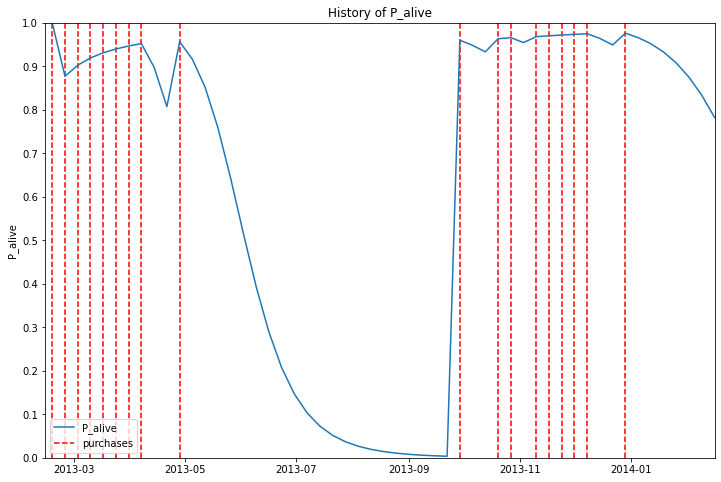

In [16]:
# probability of staying alive
plt.figure(figsize=(12, 8))
custumer = 2
days_since_birth = 52
trans_hist = churn.loc[churn["player_id_cat"] == custumer]
plot_history_alive(
    model_bgf,
    days_since_birth,
    trans_hist,
    "date",
    freq=freq,
)
plt.show()
plt.close()

We can see how the probability changes when the customer re-engage to the service.

The first purchase for this consumer was on January 2013. Five months of activity were followed by 4 months of inativity, when the probabilty was drastically reduced, and then the consumer re-engaged again.  

We can also plot the probability of being alive as a heatmap relative to frequency and recency.

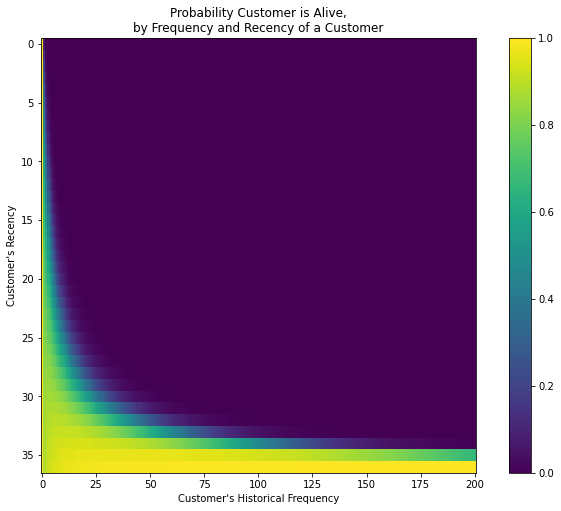

In [17]:
# probability of being alive by frequency
plt.subplots(figsize=(12, 8))
plot_probability_alive_matrix(model_bgf, max_frequency=200)
plt.show()
plt.close()

Customers who have purchased lately are more likeley to be “alive”.

We can also visualize  the number of purchases expected from a customer over a given future time interval, such as over the next 4 weeks.

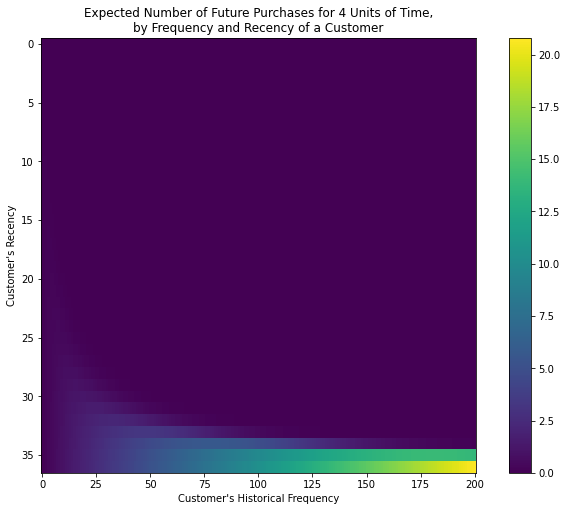

In [18]:
# future expected purchases
plt.subplots(figsize=(12, 8))

plot_frequency_recency_matrix(model_bgf, T=4, max_frequency=200)
plt.show()
plt.close()

In the previous plot, on the botton-right corner are the custumers who purchase more and recently and in the top-left corner are those who purchase a lot but not recently, and are prone to disengage. 

In general, in the last two plots the best custumers appear on the botton-right corner and the most likely to disengage appear on the top-left corner.

We can also calculate the probability of purchases expected from a customer over a given future time interval. Four weeks in our case.

In [19]:
rfm_metrics[
    "purchase_next_4_weeks"
] = model_bgf.conditional_expected_number_of_purchases_up_to_time(
    4, rfm_metrics["frequency"], rfm_metrics["recency"], rfm_metrics["T"]
)

rfm_metrics.head()

,frequency,recency,T,monetary_value,prob_alive,purchase_next_4_weeks
player_id_cat,,,,,,
1,23.0,46.0,48.0,3456.782609,0.953786,1.773636
2,17.0,45.0,46.0,1126.647059,0.966161,1.392427
4,0.0,0.0,39.0,0.000000,1.000000,0.041796
8,0.0,0.0,14.0,0.000000,1.000000,0.107560
9,2.0,8.0,18.0,9546.500000,0.620136,0.299726


Now we can use our model to predict the number of purchases expected from the customer over some number of weeks given a frequency, a recency and an age (T) for the customer.

In [20]:
# using our model to make predictions
frequency = 4
recency = 36
T = 52
t = 4

being_alive = model_bgf.conditional_probability_alive(frequency, recency, T)
expected_purchases = model_bgf.conditional_expected_number_of_purchases_up_to_time(t, frequency, recency, T)               

print(    f"Probability of Alive: {being_alive}")
print(    f"Expected Purchases in next {4} weeks: {expected_purchases}")

Probability of Alive: [0.73805765]
Expected Purchases in next 4 weeks: 0.2411686139390064


In [21]:
rfm_metrics.shape

(6808, 6)

## Saving dataset and model

In [22]:
# save dataframe to file
rfm_metrics.to_csv("../data/df_from_gb-nbd.csv", index=False)

In [23]:
# save the model
model_bgf.save_model('../models/model_bg-nbd2.pkl')